# **Desafio de regressão - Gabriel Dantas de Moraes Almeida**

## **Importação das bibliotecas**

In [101]:
import kagglehub
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## **Carregamento do banco de dados**

In [102]:
databaseFolder = kagglehub.dataset_download("arnavs19/wine-quality-uci-machine-learning-repository")
csvPath = os.path.join(databaseFolder, 'winequality-red.csv')

In [103]:
df = pd.read_csv(csvPath, sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## **Análise e tratamento do banco de dados**

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Com base no banco de dados visualizado, todas as variáveis são numéricas contínuas exceto o `quality`, que é composto por valores inteiros.

Além disso, é de suma importância visualizar se existem dados faltantes no dataset.



In [105]:
df.isnull().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


Felizmente o banco de dados está completo.

Podemos ordenar as variáveis pelo grau de correlação com a variável `quality` para compreender seus pesos.

In [106]:
def Correlations(dataframe, variableToCompare):
    correlations = []

    # Calcula a correlação entre cada coluna e a variável de interesse
    for column in dataframe.columns:
        if column != variableToCompare:
            correlation = dataframe[[column, variableToCompare]].corr().loc[variableToCompare, column]
            correlations.append((column, correlation))

    # Ordena os resultados da maior para a menor correlação
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    for col, corr in correlations:
        print(f'{col}: {corr:.3f}')

In [107]:
Correlations(df, 'quality')

alcohol: 0.476
volatile acidity: -0.391
sulphates: 0.251
citric acid: 0.226
total sulfur dioxide: -0.185
density: -0.175
chlorides: -0.129
fixed acidity: 0.124
pH: -0.058
free sulfur dioxide: -0.051
residual sugar: 0.014


Com o intuito de evitar ruídos, pode-se remover as variáveis com correlação muito baixa.

In [108]:
df = df.drop(['residual sugar', 'free sulfur dioxide', 'pH'], axis=1)

Se quisermos aprofundar a análise, podemos visualizar através de um gráfico de densidade como as notas estão distribuidas para as 4 principais variáveis:

In [109]:
def densityGraph(dataframe, X, HUE):
  plt.figure(figsize=(6, 5))
  sns.histplot(data=df, x=X, hue=HUE, kde=True, element='step', stat='density', common_norm=False, palette='Set1')

  plt.title(f'Nível de "{HUE}"')
  plt.xlabel(f'Nível de "{X}"')
  plt.ylabel('Densidade')
  plt.grid(True)
  plt.show()

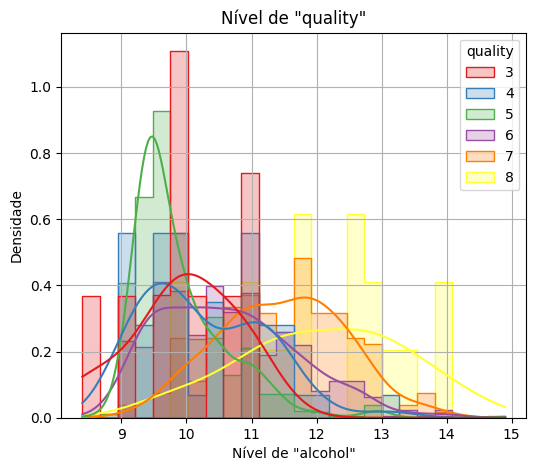

In [110]:
densityGraph(df, 'alcohol', 'quality')

Observa-se que as melhores notas estão concentradas em níveis maiores de álcool.


---



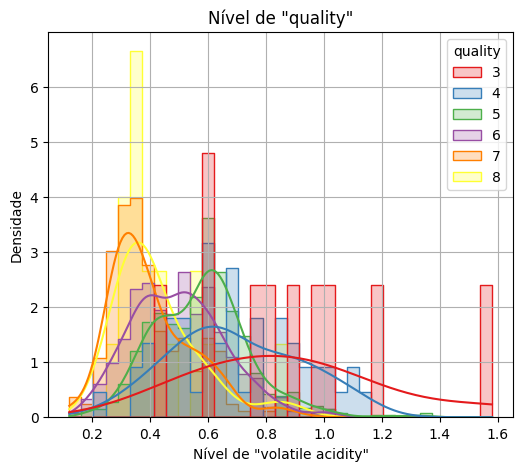

In [111]:
densityGraph(df, 'volatile acidity', 'quality')

Observa-se que as maiores notas estão concentradas em níveis menores de ácidez volátil.


---



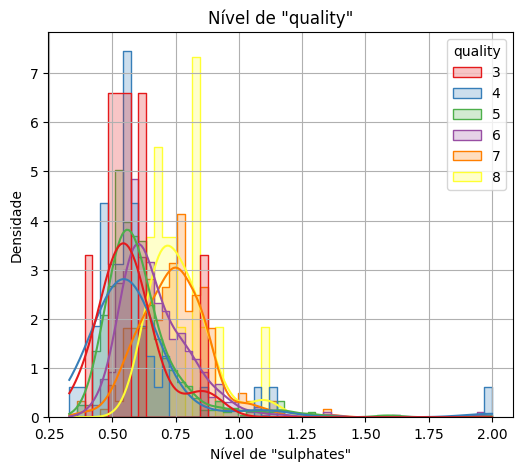

In [112]:
densityGraph(df, 'sulphates', 'quality')

Embora as notas estejam concentradas entre 0.3 e 1.25, evidencia-se que um valor entre 0.65 e 1 concentra a maior parte das notas altas.


---



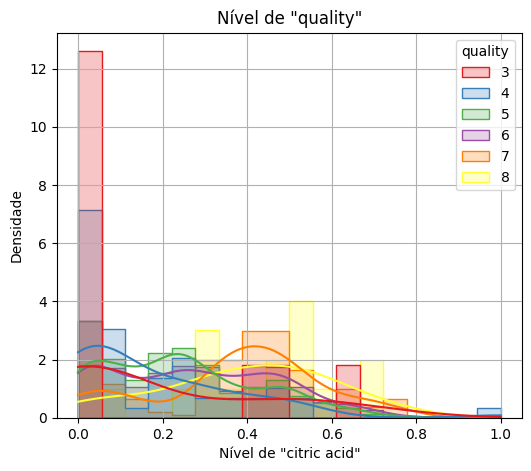

In [113]:
densityGraph(df, 'citric acid', 'quality')

Este caso é um pouco mais homogêneo, exceto do seguinte detalhe: níveis baixos de ácido cítrico favorecem notas menores.


---



Com base neste pequeno estudo, podemos criar uma nova variável que tenha potencial para auxiliar na predição do nosso modelo.

In [114]:
df['alcohol_va_ratio'] = df['alcohol']**2 / (df['volatile acidity'] + 1e-5)
Correlations(df, 'quality')

alcohol_va_ratio: 0.482
alcohol: 0.476
volatile acidity: -0.391
sulphates: 0.251
citric acid: 0.226
total sulfur dioxide: -0.185
density: -0.175
chlorides: -0.129
fixed acidity: 0.124


Evidentemente a nova variável está fortemente correlacionada com o quality. Esta é uma variável potencialmente útil para obter uma melhor performance.

## **Implementação do modelo de regressão**

Como mutias das variáveis não se comportam de maneira linear, optou-se por utilizar o modelo de **Random Forest Regressor**.

Inicialmente dividimos as variáveis livres da variável alvo.

Em seguida, fez-se a divisão do conjunto de dados em duas partes: uma para treinamento e outra para o teste dos modelos.

Para que o modelo obtenha um melhor resultado, colocou-se todos os dados na mesma escala através de um `scaler`.

In [115]:
X = df.drop('quality', axis=1)
y = df['quality']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Colocar os dados na mesma escala
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Podemos definir o modelo de **Random Forest Regressor** especificando alguns parâmetros:

In [116]:
model = RandomForestRegressor(
    random_state=42,         # Garante reprodutibilidade
    n_estimators=500,        # Número de árvores na floresta
    max_depth=50,            # Profundidade máxima de cada árvore
    min_samples_split=2,     # Mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=1,      # Mínimo de amostras que um nó folha deve conter
    max_features=2           # Máximo de features consideradas para encontrar a melhor divisão em cada nó
)


model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [117]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R²: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

R²: 0.553
RMSE: 0.292
MAE: 0.416


## **Interpretação dos dados obtidos**

Com base nos resultados obtidos, podemos analisar o que cada métrica nos indica:



*   **R²:** nosso modelo foi capaz de compreender cerca de 55,3% da variância do banco de dados;
*   **RMSE:** essa métrica nos indica o quanto as previsões do modelo tendem a se afastar dos valores reais em média. Nosso modelo teve um erro médio quadrático de 0,292 na nota dada ao vinho;
*   **MAE:** essa métrica mede a média dos erros absolutos entre os valores previstos pelo modelo e os valores reais observados. Nosso modelo teve um erro médio absoluto de 0,416 na nota dada ao vinho. Isso significa que ao prever uma nota x, o erro médio esperado é de cerca de ±0,416 pontos.


Segundo este
[artigo](https://www.researchgate.net/publication/369154164_The_Acceptable_R-Square_in_Empirical_Modelling_for_Social_Science_Research), para experimentos sociais e empíricos, um R² entre 0,51 e 0,99 é o usual.

Isso ocorre pois a predição de um comportamento subjetivo tende a ser menos precisa, por depender de outros fatores externos.

Além disso, é provável que o banco de dados não expresse completamente as variáveis necessárias para determinar a nota do vinho. O trecho tirado do próprio banco de dados explicita isso:

> "Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.)"


Diante desse cenário, conclui-se que os resultados obtidos são satisfatórios e esperados.
